# Определение стоимости автомобилей

## Описание задачи

- Заказчик — сервис по продаже автомобилей с пробегом «Не бит, не крашен»
- Заказчик разрабатывает приложение для привлечения новых клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля
- Разработать модель для наиболее точной оценки стоимости автомобилей
- Для оценки качества моделей использовать метрику RMSE
- Значение метрики RMSE должно быть меньше 2500
- Самостоятельно освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга
- Измерить время выполнения градиентного бустинга, обучение долгое, изменить только два-три параметра
- Заказчику важны:
    - качество предсказания
    - скорость предсказания
    - время обучения

## Описание данных

Исторические данные о продаже автомобилей и их характеристиках

**Признаки**
- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *Repaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**
- *Price* — цена (евро)

## Задача в терминах ML

- стоимость автомобиля — задача регрессии
- метрика RMSE менее 2500

## Подключение библиотек

In [1]:
# !pip install lightgbm xgboost

In [2]:
import time

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

import warnings

from xgboost import XGBRegressor

from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, make_scorer # RMSE. Нужно поставить squared=True
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures

from joblib import dump, load

from IPython.display import display, Markdown

# Константы
RANDOM_STATE = 12345

# Отключение предупреждений
warnings.filterwarnings('ignore')

In [3]:
def plot_pie(series: pd.Series, title: str) -> None:
    """Отрисовка круговой диаграммы"""
    
    vc = series.value_counts()
    labels = pd.Series(vc.values) / sum(vc.values)
    labels = [f'{vc.keys()[i]}, {vc[i]} ({label:.2%})' for i, label in enumerate(labels)]
    ax = plt.pie(vc, labels=labels)
    plt.title(title);
    return ax

In [4]:
def make_remove_decision(src, for_remove):
    """Делаем вывод об удалении данных если их меньше 10%"""
    if len(for_remove) < len(src) * 0.10:
        return " Менее 10%, удаляем данные."
    return " Более 10%, оставляем данные."

## Функция для поиска и учёта наилучшей модели и гиперпараметров

In [5]:
# Новый код
everything_line = [
    {
        'model': LinearRegression(),
        'param_grid': {}
    },
    {
        'model': SGDRegressor(max_iter=100),
        'param_grid': {
            'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
            'penalty': ['l2']
        }
    },
    {
        'model': XGBRegressor(random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [20],
            'max_depth': [9]
        }
    },
]

everything_boosting = [
    {
        # {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 20, 'num_leaves': 9}
        'model': lgb.LGBMRegressor(objective='regression', random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [20],
            'max_depth': [6, 8],
            'num_leaves': [5, 7, 9],
            'learning_rate': [1, 0.1],
        }
    },
    {
        'model': CatBoostRegressor(logging_level='Silent', random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [20],
            'depth': [4, 6, 8, 9],
            'learning_rate': [0.1, 0.01, 1],
        }
    }
]

def make_good(features, target, param_grid_grid, categorial_columns=[]):
    """
    Получение лучшей модели добавив перебор архитектур как гиперпараметр,
    перебором гиперпараметров.
    И добавление журналирования действий для воспроизводимости.
    """
    grids = []
    results = []
    
    for param_grid in param_grid_grid:
        grid = GridSearchCV(param_grid['model'], param_grid=param_grid['param_grid'],
                            scoring='neg_root_mean_squared_error', cv=5)

        start = time.time()
        if param_grid['model'].__class__ == 'LGBMRegressor':
            X = features.astype(dict.fromkeys(categorial_columns, 'category')).copy()
            experiments = grid.fit(X, target, categorical_feature=categorial_columns)
        else:
            experiments = grid.fit(features, target)
        end = time.time()
        grid_time = end - start
        print(grid_time)

        result = pd.DataFrame(experiments.cv_results_)
        result['grid_time'] = grid_time

        mean_fit_time= grid.cv_results_['mean_fit_time']
        mean_score_time= grid.cv_results_['mean_score_time']
        n_splits  = grid.n_splits_
        
        # Время на одну модель (один набор параметров, под разные разделения данных)
        result['model_time'] = np.mean(mean_fit_time + mean_score_time) * n_splits
        result['model'] = str(param_grid['model'].__class__).split('.')[-1][:-2]
        result['mean_test_score'] = result['mean_test_score'].abs()
        
        grids.append(grid)
        results.append(result)
    
    results = pd.concat([*results], axis=0)
    
    return grids, results

## Получение данных

In [6]:
df = pd.read_csv('./data/autos.csv')

## Изучение данных

In [7]:
origin_len_data = df.shape[0]
redline = int(origin_len_data * 0.90)
f'До какого количества данные можно удалить: {redline}'

'До какого количества данные можно удалить: 318932'

In [8]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


## Предобработка данных

Для каждого признака проверямем и применяем:
- адекватность данных
- тип для корректной работы и сохранения памяти
- змениный регистр для сохранения исходных признаков и единства стиля 

Преобразуем тип данных в более подходящий

In [11]:
df['registration_month'] = df['RegistrationMonth']
df['registration_year'] = df['RegistrationYear'].astype(np.uint16)
df['date_crawled'] = df['DateCrawled'].astype('datetime64')
df['date_created'] = df['DateCreated'].astype('datetime64')
df['last_seen'] = df['LastSeen'].astype('datetime64')
df['price'] = df['Price']

### Дата скачивания анкеты из базы

In [12]:
df['date_crawled'].describe(datetime_is_numeric=True)

count                           354369
mean     2016-03-21 12:58:10.450648320
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: date_crawled, dtype: object

### Тип автомобильного кузова

Заполняем пропуски `VehicleType` значением `unspecified` как отдельной категорией

In [13]:
df['vehicle_type'] = df['VehicleType'].fillna('unspecified')

### Дата создания анкеты

In [14]:
df['date_created'].describe(datetime_is_numeric=True)

count                           354369
mean     2016-03-20 19:12:07.753274112
min                2014-03-10 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: date_created, dtype: object

### Год регистрации автомобиля

Есть неадекватные значения.

In [15]:
df.shape[0]

354369

In [16]:
manufacture_year_first_vehicle = 1885
now_year = 2023

# Записи в адекватном диапазоне регистрации автомобиля
# и только те года что меньше даты создания записи
real_years = df.query('@manufacture_year_first_vehicle < RegistrationYear < @now_year \
                       and RegistrationYear <= date_created.dt.year')
display(Markdown(
    f'Количество данных о машинах вне адекватного \
      диапазона {len(df) - len(real_years)}. {make_remove_decision(df, df[~df.index.isin(real_years.index)])}'
))

Количество данных о машинах вне адекватного       диапазона 14596.  Менее 10%, удаляем данные.

In [17]:
df = df[df.index.isin(real_years.index)]
df.shape[0], redline

(339773, 318932)

### Тип коробки передач

In [18]:
len(df[df['Gearbox'].isna()])

17909

Есть пропуски.

In [19]:
display(Markdown(f'Восстановить не получиться. {make_remove_decision(df, df[df["Gearbox"].isna()])}'))

Восстановить не получиться.  Менее 10%, удаляем данные.

In [20]:
df = df[~df['Gearbox'].isna()]
df.shape[0]

321864

In [21]:
df['gearbox'] = df['Gearbox']

### Мощность автомобиля

По 2028 лошадиных сил примим за адекватные значения, остальные данные удалим.

In [22]:
maximum_known_power = 2028
df[df['Power'] > maximum_known_power]['Power'].shape[0]

94

In [23]:
df = df[df['Power'] < maximum_known_power]
df.shape[0]

321770

Все нулевые значения заполним медианой

In [24]:
len(df[df['Power'] == 0]['Power'])

24319

In [25]:
df.loc[df['Power'] == 0, 'Power'] = df['Power'].median()

In [26]:
df['power'] = df['Power'].astype('uint16')

### Модель автомобиля

In [27]:
df[df['Model'].isna()].shape[0]

13932

Заполним пропуски `Model` значением `unspecified` как отдельной категорией

In [28]:
df['model'] = df['Model'].fillna('unspecified')

### Пробег автомобиля 

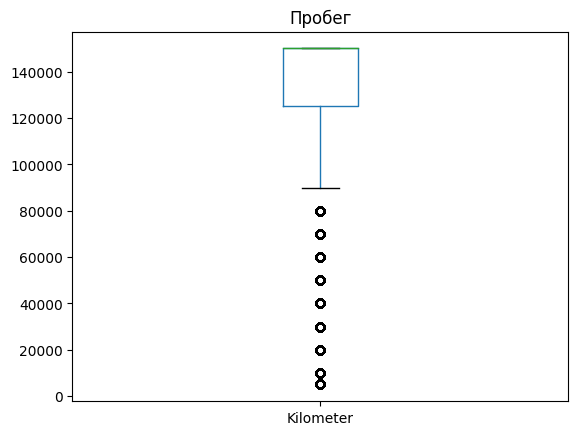

In [29]:
df['Kilometer'].plot(kind='box', title='Пробег');

In [30]:
df['kilometer'] = df['Kilometer'].astype('uint16')

### Месяц регистрации автомобиля

In [31]:
df['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

13 категорий в столбце с месяцем. Предположим и оставим 0 как отдельную категорию "не указанный месяц"

In [32]:
df['registration_month'] = df['RegistrationMonth']

### Тип топлива автомобиля

In [33]:
df[df['FuelType'].isna()].shape[0]

19137

Есть пропуски.

In [34]:
df['FuelType'].value_counts()

petrol      203658
gasoline     92966
lpg           5036
cng            529
hybrid         221
other          145
electric        78
Name: FuelType, dtype: int64

Заполняем пропуски `FuelType` значением `unspecified` как отдельной категорией

In [35]:
df['fuel_type'] = df['FuelType'].fillna('unspecified')

### Марка автомобиля

In [36]:
df[df['Brand'].isna()].shape[0]

0

In [37]:
df['brand'] = df['Brand']

### Была машина в ремонте или нет

In [38]:
df[df['Repaired'].isna()].shape[0]

53293

Пропусков довольно много

In [39]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Бинарный признак, приведём к типу `bool`. И тут же поменяем название колонки.

In [40]:
df['repaired'] = df['Repaired'].map({'yes': True, 'no': False})
df['repaired'].unique()

array([nan, True, False], dtype=object)

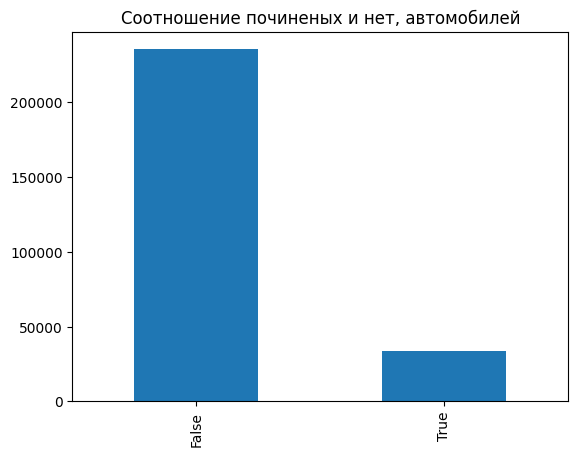

In [41]:
df['repaired'].value_counts().plot(kind='bar', title='Соотношение починеных и нет, автомобилей');

In [42]:
x = df['repaired'].value_counts().values
ratio = int(x[0] / x[1]) / 100
print('Соотношение починенных машин к непочиненным:', ratio, ':',  1 - ratio)

Соотношение починенных машин к непочиненным: 0.07 : 0.9299999999999999


Заполним пропуски `repaired` случайными `False` / `True` значениями в этом соотношении

In [43]:
reidx = df[df['repaired'].isna()].index
df.loc[df['repaired'].index.isin(reidx), 'repaired'] = \
    pd.Series(np.random.choice([True, False], reidx.shape[0], p=[ratio, 1 - ratio]), index=reidx)

In [44]:
df['repaired'].unique()

array([False, True], dtype=object)

In [45]:
df[df['repaired'].isna()].shape[0]

0

Пропусков не осталось

### Количество фотографий автомобиля

In [46]:
df['NumberOfPictures'].value_counts()

0    321770
Name: NumberOfPictures, dtype: int64

Признак с количеством фотографий состоит только из нулей, данные прочитались корректно, возможно сбой выгрузки данных, исключаем признак из рассмотрения. 

### Почтовый индекс владельца анкеты

In [47]:
len(df['PostalCode'].isna())

321770

Явных аномалий нет

In [48]:
df['postal_code'] = df['PostalCode']

### Дата последней активности пользователя

In [49]:
df['last_seen'].describe(datetime_is_numeric=True)

count                           321770
mean     2016-03-30 02:36:53.910600704
min                2016-03-05 14:15:08
25%         2016-03-23 09:46:25.500000
50%         2016-04-03 20:42:29.500000
75%                2016-04-06 10:17:54
max                2016-04-07 14:58:51
Name: last_seen, dtype: object

In [50]:
df[df['last_seen'].isna()].shape[0]

0

Явных аномалий нет

### Цена в евро

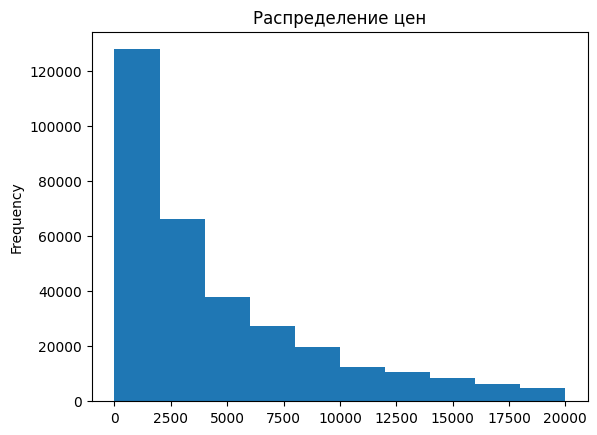

In [51]:
df['price'].plot(kind='hist', title='Распределение цен');

In [52]:
df['price'].describe()

count    321770.000000
mean       4597.830071
std        4580.141702
min           0.000000
25%        1199.000000
50%        2900.000000
75%        6700.000000
max       20000.000000
Name: price, dtype: float64

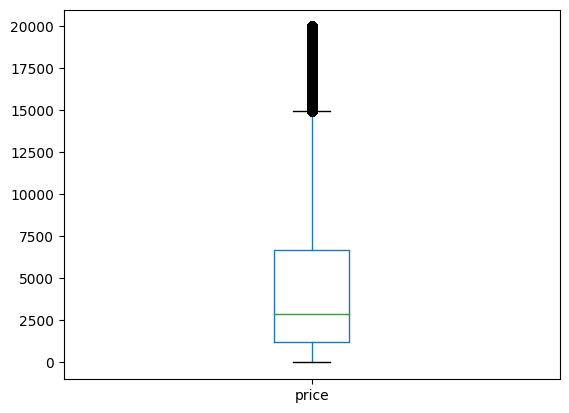

In [53]:
df['price'].plot(kind='box');

In [54]:
df[df['price'] < 100].shape[0]

9132

Здесь в целом непонятно, наличие очень маленьких значений цены. Отдают машины просто так или нужно максимизировать прибыль, задачи такой не стоит, если машины с такими характеристиками продавались за очень низкую цену или вообще без неё это тоже придётся учитывать в задаче точной оценки стоимости машины. Оставляем признак как есть

In [55]:
df[df['Price'] == 0].shape[0]

7695

Количество данных с нулевой ценой. Заменим нули медианными значениями

In [56]:
df.loc[df['Price'] == 0, 'price'] = df['Price'].median()

In [57]:
df[df['price'] == 0].shape[0]

0

Аномальных значений не осталось

### Проверка предобработки

In [58]:
all_columns = [
    'brand', 'model', 'power', 'repaired', 'price', 'vehicle_type', 'gearbox', 'kilometer',  'fuel_type',
    'postal_code', 'registration_year', 'registration_month', 'date_created', 'date_crawled', 'last_seen'
]

In [59]:
# clear dataframe
cdf = df[all_columns].copy().reset_index(drop=True)
cdf.head()

,brand,model,power,repaired,price,vehicle_type,gearbox,kilometer,fuel_type,postal_code,registration_year,registration_month,date_created,date_crawled,last_seen
0,volkswagen,golf,105,False,480.0,unspecified,manual,18928,petrol,70435,1993,0,2016-03-24,2016-03-24 11:52:17,2016-04-07 03:16:57
1,audi,unspecified,190,True,18300.0,coupe,manual,59464,gasoline,66954,2011,5,2016-03-24,2016-03-24 10:58:45,2016-04-07 01:46:50
2,jeep,grand,163,False,9800.0,suv,auto,59464,gasoline,90480,2004,8,2016-03-14,2016-03-14 12:52:21,2016-04-05 12:47:46
3,volkswagen,golf,75,False,1500.0,small,manual,18928,petrol,91074,2001,6,2016-03-17,2016-03-17 16:54:04,2016-03-17 17:40:17
4,skoda,fabia,69,False,3600.0,small,manual,24464,gasoline,60437,2008,7,2016-03-31,2016-03-31 17:25:20,2016-04-06 10:17:21


In [60]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321770 entries, 0 to 321769
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   brand               321770 non-null  object        
 1   model               321770 non-null  object        
 2   power               321770 non-null  uint16        
 3   repaired            321770 non-null  object        
 4   price               321770 non-null  float64       
 5   vehicle_type        321770 non-null  object        
 6   gearbox             321770 non-null  object        
 7   kilometer           321770 non-null  uint16        
 8   fuel_type           321770 non-null  object        
 9   postal_code         321770 non-null  int64         
 10  registration_year   321770 non-null  uint16        
 11  registration_month  321770 non-null  int64         
 12  date_created        321770 non-null  datetime64[ns]
 13  date_crawled        321770 no

In [61]:
cdf.describe()

,power,price,kilometer,postal_code,registration_year,registration_month
count,321770.000000,321770.000000,321770.000000,321770.000000,321770.000000,321770.000000
mean,120.549678,4667.182404,25238.141927,50735.731585,2002.606993,5.891671
std,62.091090,4531.695949,14640.033022,25819.691301,6.745219,3.639239
min,1.000000,1.000000,4464.000000,1067.000000,1910.000000,0.000000
25%,82.000000,1299.000000,18928.000000,30419.000000,1999.000000,3.000000
50%,105.000000,2900.000000,18928.000000,49593.000000,2003.000000,6.000000
75%,143.000000,6700.000000,20000.000000,71364.000000,2007.000000,9.000000
max,2018.000000,20000.000000,60000.000000,99998.000000,2016.000000,12.000000


## Анализ данных

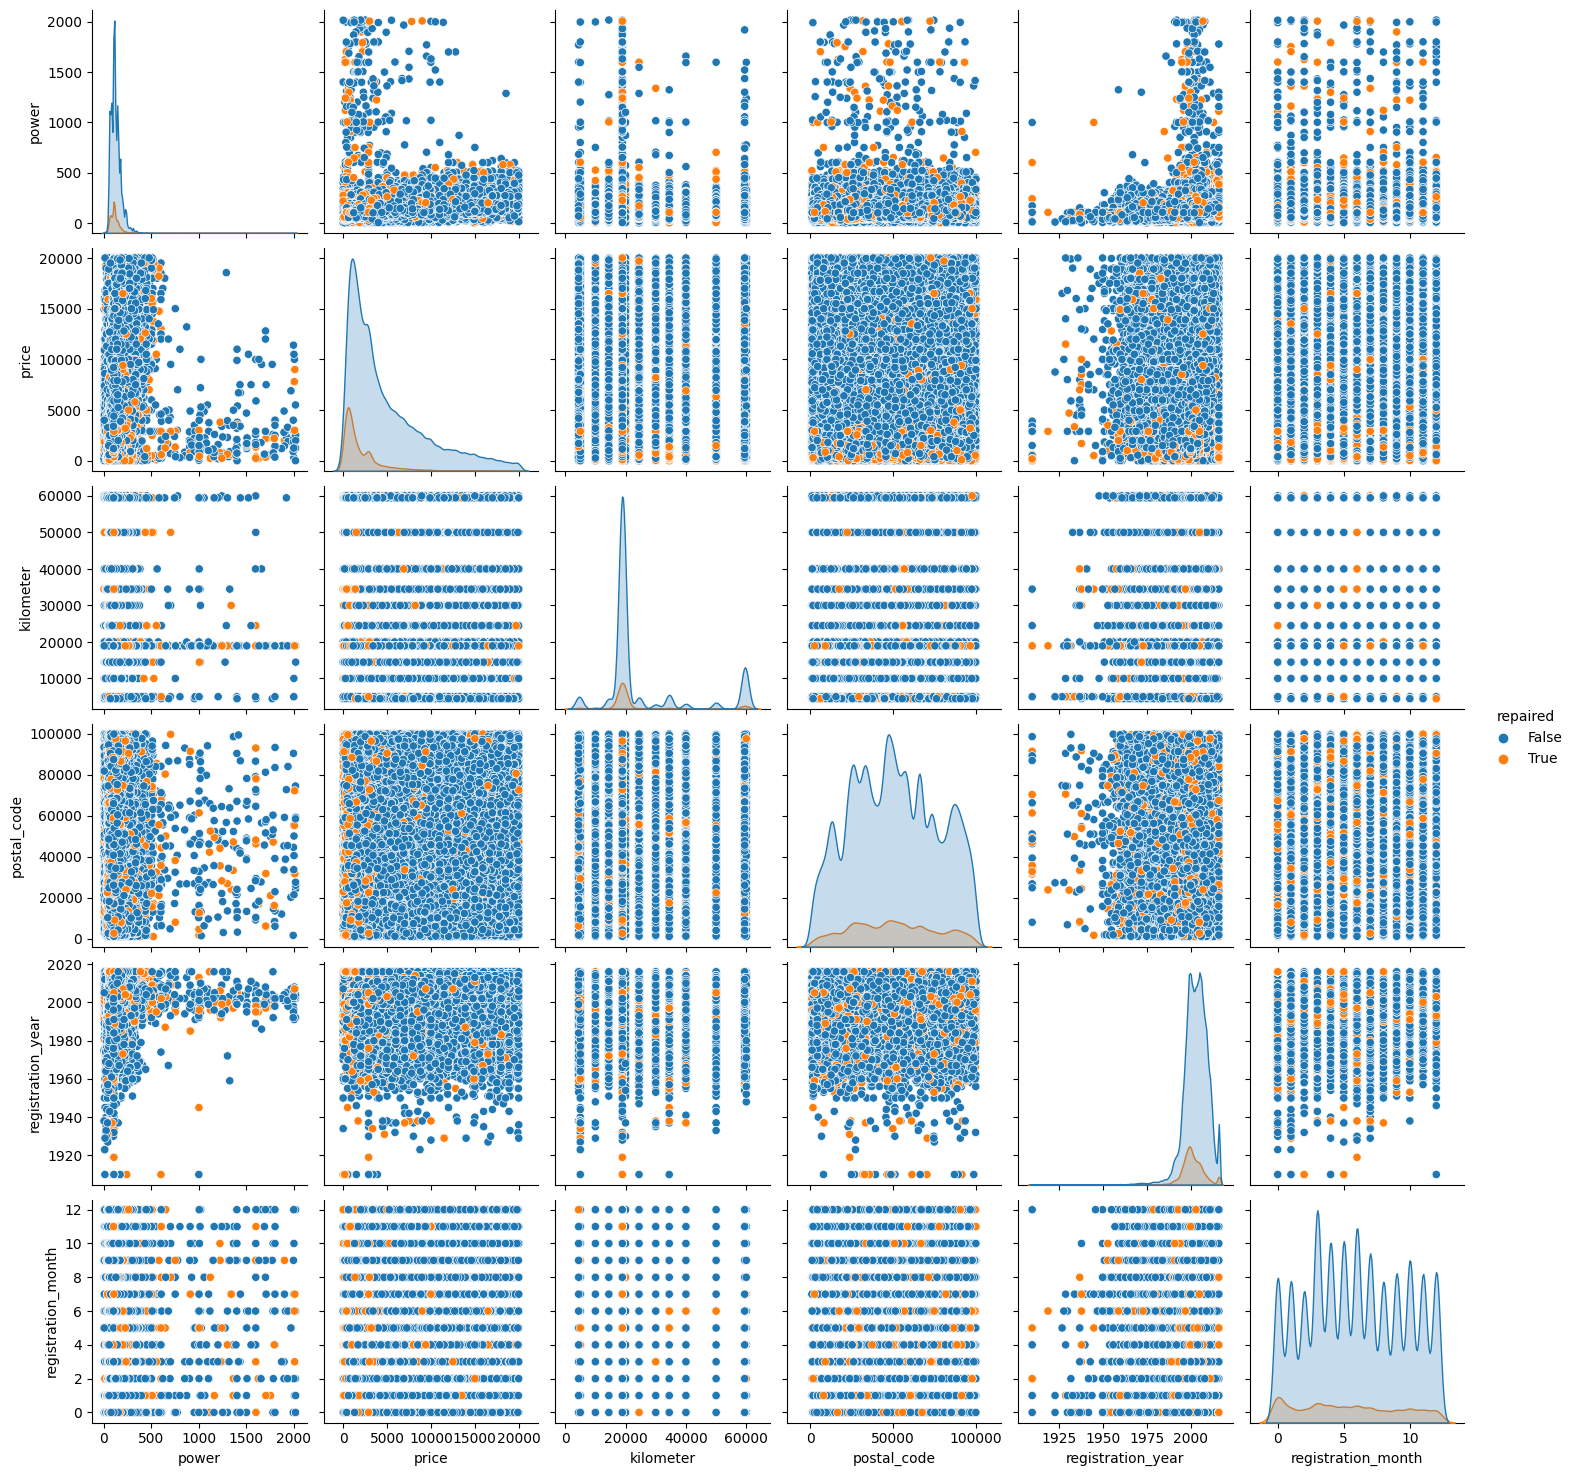

In [62]:
sns.pairplot(cdf, hue='repaired');

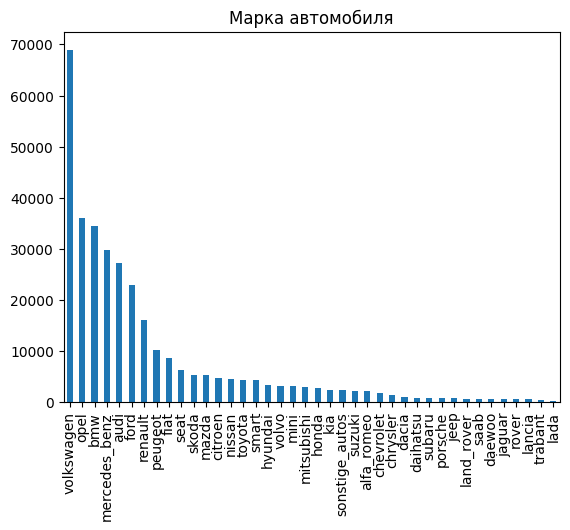

In [63]:
cdf['brand'].value_counts().plot(kind='bar', title='Марка автомобиля');

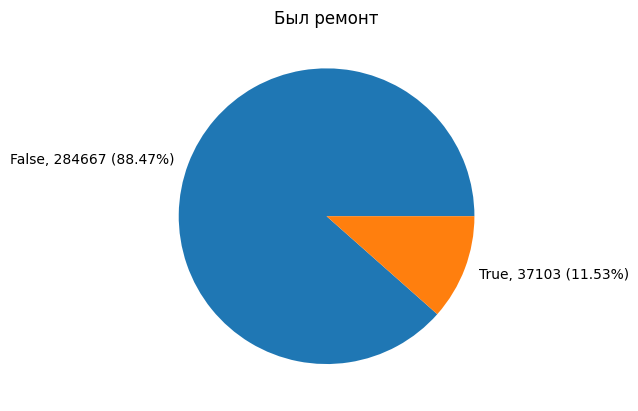

In [64]:
plot_pie(cdf['repaired'], 'Был ремонт');

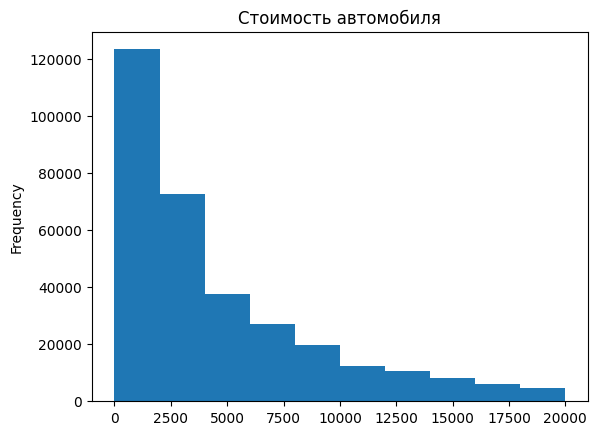

In [65]:
cdf['price'].plot(kind='hist', title='Стоимость автомобиля');

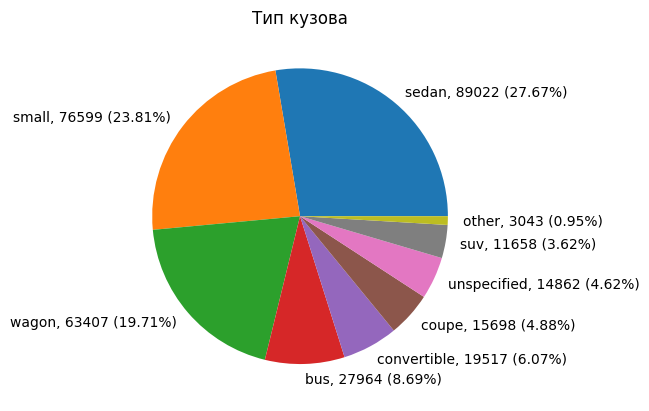

In [66]:
plot_pie(cdf['vehicle_type'], 'Тип кузова');

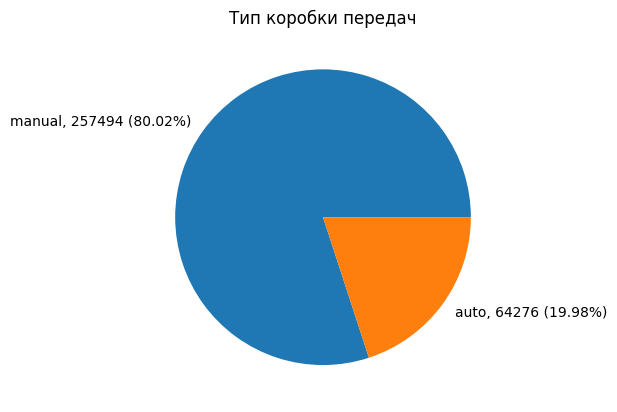

In [67]:
plot_pie(cdf['gearbox'], 'Тип коробки передач');

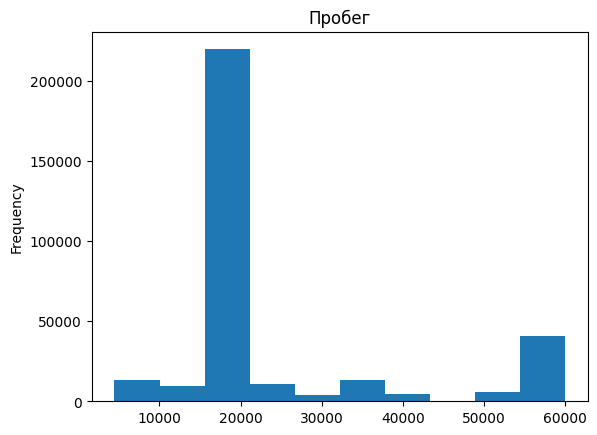

In [68]:
cdf['kilometer'].plot(kind='hist', title='Пробег');

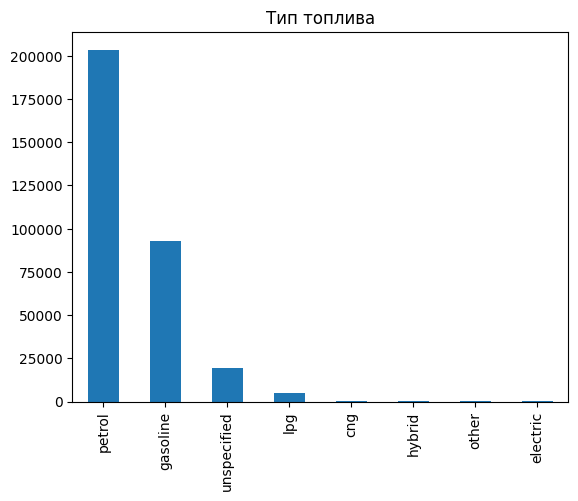

In [69]:
cdf['fuel_type'].value_counts().plot(kind='bar', title='Тип топлива');

## Предобработка призканов

Разделим признаки на категориальные и числовые.

In [70]:
categorial_columns = ['brand', 'model', 'repaired', 'vehicle_type', 'gearbox', 'fuel_type',
                      'postal_code', 'registration_year', 'registration_month']
numeric_columns = ['power', 'price', 'kilometer']

In [71]:
cdf[categorial_columns].head()

,brand,model,repaired,vehicle_type,gearbox,fuel_type,postal_code,registration_year,registration_month
0,volkswagen,golf,False,unspecified,manual,petrol,70435,1993,0
1,audi,unspecified,True,coupe,manual,gasoline,66954,2011,5
2,jeep,grand,False,suv,auto,gasoline,90480,2004,8
3,volkswagen,golf,False,small,manual,petrol,91074,2001,6
4,skoda,fabia,False,small,manual,gasoline,60437,2008,7


In [72]:
cdf[numeric_columns].head()

,power,price,kilometer
0,105,480.0,18928
1,190,18300.0,59464
2,163,9800.0,59464
3,75,1500.0,18928
4,69,3600.0,24464


### Полиномиальные признаки

In [73]:
for_polynomial = cdf[numeric_columns].drop('price', axis=1)
for_polynomial

,power,kilometer
0,105,18928
1,190,59464
2,163,59464
3,75,18928
4,69,24464
...,...,...
321765,105,18928
321766,105,18928
321767,101,59464
321768,102,18928


In [74]:
pl = PolynomialFeatures(2, include_bias=False)
pl.fit(for_polynomial)

cdf_line_pl = pd.DataFrame(
    pl.transform(for_polynomial),
    columns=pl.get_feature_names(),
    index=for_polynomial.index
).drop(['x0', 'x1'], axis=1)

cdf_line_pl.head()

,x0^2,x0 x1,x1^2
0,11025.0,1987440.0,3.582692e+08
1,36100.0,11298160.0,3.535967e+09
2,26569.0,9692632.0,3.535967e+09
3,5625.0,1419600.0,3.582692e+08
4,4761.0,1688016.0,5.984873e+08


In [75]:
pl = PolynomialFeatures(2, include_bias=False)
pl.fit(for_polynomial)

cdf_line_pl = pd.DataFrame(
    pl.transform(for_polynomial),
    columns=pl.get_feature_names(),
    index=for_polynomial.index
).drop(['x0', 'x1'], axis=1)

cdf_line_pl.head()

,x0^2,x0 x1,x1^2
0,11025.0,1987440.0,3.582692e+08
1,36100.0,11298160.0,3.535967e+09
2,26569.0,9692632.0,3.535967e+09
3,5625.0,1419600.0,3.582692e+08
4,4761.0,1688016.0,5.984873e+08


### Для линейных моделей и XGBRegressor

Применяем технику One Hot Encoding с помощью `get_dummies()` до разделения на выборки чтобы избежать ошибки неизвестных категорий для категориальных признаков на тестовой выборке. (`drop_first=True` избегаем дамми-ловушки лишних признаков).

И собираем всё в один датасет: численные признаки, их полиномиальные версии и прямо кодированне категориальные.

In [76]:
cdf_line_pl_ohe = pd.concat([
    cdf[numeric_columns],
    cdf_line_pl,
    pd.get_dummies(cdf[categorial_columns], drop_first=True)
], axis=1)

categorial_columns_line_pl_ohe = set(cdf_line_pl_ohe.columns) - set(cdf[numeric_columns])
display(Markdown(f'Теперь количество категориальных признаков: {len(categorial_columns_line_pl_ohe)}'))

cdf_line_pl_ohe

Теперь количество категориальных признаков: 312

,power,price,kilometer,x0^2,x0 x1,x1^2,postal_code,registration_year,registration_month,brand_audi,...,vehicle_type_unspecified,vehicle_type_wagon,gearbox_manual,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unspecified
0,105,480.0,18928,11025.0,1987440.0,3.582692e+08,70435,1993,0,0,...,1,0,1,0,0,0,0,0,1,0
1,190,18300.0,59464,36100.0,11298160.0,3.535967e+09,66954,2011,5,1,...,0,0,1,0,1,0,0,0,0,0
2,163,9800.0,59464,26569.0,9692632.0,3.535967e+09,90480,2004,8,0,...,0,0,0,0,1,0,0,0,0,0
3,75,1500.0,18928,5625.0,1419600.0,3.582692e+08,91074,2001,6,0,...,0,0,1,0,0,0,0,0,1,0
4,69,3600.0,24464,4761.0,1688016.0,5.984873e+08,60437,2008,7,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321765,105,1150.0,18928,11025.0,1987440.0,3.582692e+08,26624,2000,3,0,...,0,0,1,0,0,0,0,0,1,0
321766,105,2900.0,18928,11025.0,1987440.0,3.582692e+08,2694,2005,7,0,...,1,0,1,0,0,0,0,0,1,0
321767,101,1199.0,59464,10201.0,6005864.0,3.535967e+09,26135,2000,3,0,...,0,0,0,0,0,0,0,0,1,0
321768,102,9200.0,18928,10404.0,1930656.0,3.582692e+08,87439,1996,3,0,...,0,0,1,0,1,0,0,0,0,0


#### Разделяем на обучающую и тестовую выборки

In [77]:
features_train_line_pl_ohe, features_test_line_pl_ohe, target_train, target_test = \
    train_test_split(
        cdf_line_pl_ohe.drop('price', axis=1),
        cdf_line_pl_ohe['price'],
        train_size=0.75, random_state=RANDOM_STATE
)
features_train_line_pl_ohe.shape, features_test_line_pl_ohe.shape, target_train.shape, target_test.shape

((241327, 314), (80443, 314), (241327,), (80443,))

#### Применяем масштабирование

In [78]:
scaler_line_train = StandardScaler()
scaler_line_train.fit(features_train_line_pl_ohe)

features_train_line_pl_ohe_sc = pd.DataFrame(
    scaler_line_train.transform(features_train_line_pl_ohe),
    columns=features_train_line_pl_ohe.columns,
    index=features_train_line_pl_ohe.index
)

features_test_line_pl_ohe_sc = pd.DataFrame(
    scaler_line_train.transform(features_test_line_pl_ohe),
    columns=features_test_line_pl_ohe.columns,
    index=features_test_line_pl_ohe.index
)

In [79]:
features_train_line_pl_ohe_sc

,power,kilometer,x0^2,x0 x1,x1^2,postal_code,registration_year,registration_month,brand_audi,brand_bmw,...,vehicle_type_unspecified,vehicle_type_wagon,gearbox_manual,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unspecified
25791,-0.072926,-0.431234,-0.078998,-0.342976,-0.452226,0.909927,0.205387,1.127566,-0.303766,-0.345904,...,-0.218994,-0.496324,-1.999803,-0.015638,-0.638652,-0.026078,-0.12667,-0.021355,0.762424,-0.250461
267882,-0.724879,2.337569,-0.201743,0.623187,2.461503,-1.908883,-0.981943,0.028822,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,-0.638652,-0.026078,-0.12667,-0.021355,0.762424,-0.250461
59237,-0.311446,2.337569,-0.130017,1.282926,2.461503,-0.643219,-0.536694,-0.520550,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,-0.638652,-0.026078,-0.12667,-0.021355,0.762424,-0.250461
88329,-0.899793,2.337569,-0.225709,0.344066,2.461503,0.355143,0.205387,-1.619294,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,-0.638652,-0.026078,-0.12667,-0.021355,0.762424,-0.250461
268287,1.755721,2.337569,0.546486,4.581622,2.461503,1.268253,0.205387,-1.344608,-0.303766,2.890977,...,-0.218994,-0.496324,-1.999803,-0.015638,-0.638652,-0.026078,-0.12667,-0.021355,0.762424,-0.250461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158838,0.070185,-0.431234,-0.045000,-0.270283,-0.452226,0.904039,-0.091445,1.402252,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,1.565797,-0.026078,-0.12667,-0.021355,-1.311606,-0.250461
47873,-0.724879,-0.431234,-0.201743,-0.674133,-0.452226,-0.488904,-0.388278,0.578194,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,-0.638652,-0.026078,-0.12667,-0.021355,0.762424,-0.250461
86398,-0.724879,-0.431234,-0.201743,-0.674133,-0.452226,-0.897157,0.205387,1.127566,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,1.565797,-0.026078,-0.12667,-0.021355,-1.311606,-0.250461
77285,-0.836188,-0.431234,-0.217433,-0.730672,-0.452226,-0.785720,0.353804,-1.619294,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,1.565797,-0.026078,-0.12667,-0.021355,-1.311606,-0.250461


In [80]:
features_test_line_pl_ohe_sc

,power,kilometer,x0^2,x0 x1,x1^2,postal_code,registration_year,registration_month,brand_audi,brand_bmw,...,vehicle_type_unspecified,vehicle_type_wagon,gearbox_manual,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unspecified
103209,-0.247841,-0.431234,-0.117102,-0.431823,-0.452226,-0.796798,0.205387,1.676938,-0.303766,-0.345904,...,-0.218994,-0.496324,-1.999803,-0.015638,1.565797,-0.026078,-0.126670,-0.021355,-1.311606,-0.250461
85334,1.549004,-0.431234,0.454995,0.480877,-0.452226,1.454794,0.947469,-0.795236,-0.303766,-0.345904,...,-0.218994,2.014815,-1.999803,-0.015638,1.565797,-0.026078,-0.126670,-0.021355,-1.311606,-0.250461
136253,-0.072926,-0.431234,-0.078998,-0.342976,-0.452226,-0.527754,-1.427191,-0.520550,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,-0.638652,-0.026078,-0.126670,-0.021355,0.762424,-0.250461
279805,-0.963398,-0.431234,-0.233484,-0.795288,-0.452226,0.336396,-0.685110,1.676938,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,-0.638652,-0.026078,-0.126670,-0.021355,0.762424,-0.250461
6443,2.153253,2.337569,0.737321,5.215987,2.461503,0.485056,0.502220,1.402252,3.292005,-0.345904,...,-0.218994,-0.496324,-1.999803,-0.015638,-0.638652,-0.026078,-0.126670,-0.021355,0.762424,-0.250461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320093,-0.009321,-0.431234,-0.064201,-0.310668,-0.452226,1.308923,0.205387,-0.245864,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,-0.638652,-0.026078,-0.126670,-0.021355,0.762424,-0.250461
292725,-0.311446,2.337569,-0.130017,1.282926,2.461503,-0.196580,-0.833526,0.852880,-0.303766,-0.345904,...,-0.218994,-0.496324,0.500049,-0.015638,-0.638652,-0.026078,-0.126670,-0.021355,0.762424,-0.250461
122421,3.170934,-1.419194,1.315139,-0.670344,-0.762462,0.503494,-1.427191,1.676938,-0.303766,-0.345904,...,-0.218994,-0.496324,-1.999803,-0.015638,-0.638652,-0.026078,-0.126670,-0.021355,0.762424,-0.250461
139814,0.372309,-0.431234,0.035111,-0.116820,-0.452226,-1.091949,-0.091445,1.127566,-0.303766,-0.345904,...,-0.218994,-0.496324,-1.999803,-0.015638,-0.638652,-0.026078,-0.126670,-0.021355,0.762424,-0.250461


### Для моделей бустингов

Соберём численные признаки, их полиномиальные версии и категориальне признаки (их оставляем "как есть") в один датасет.

In [81]:
cdf_boosting_pl = pd.concat([
    cdf[numeric_columns],
    cdf_line_pl,
    cdf[categorial_columns]
], axis=1)

cdf_boosting_pl

,power,price,kilometer,x0^2,x0 x1,x1^2,brand,model,repaired,vehicle_type,gearbox,fuel_type,postal_code,registration_year,registration_month
0,105,480.0,18928,11025.0,1987440.0,3.582692e+08,volkswagen,golf,False,unspecified,manual,petrol,70435,1993,0
1,190,18300.0,59464,36100.0,11298160.0,3.535967e+09,audi,unspecified,True,coupe,manual,gasoline,66954,2011,5
2,163,9800.0,59464,26569.0,9692632.0,3.535967e+09,jeep,grand,False,suv,auto,gasoline,90480,2004,8
3,75,1500.0,18928,5625.0,1419600.0,3.582692e+08,volkswagen,golf,False,small,manual,petrol,91074,2001,6
4,69,3600.0,24464,4761.0,1688016.0,5.984873e+08,skoda,fabia,False,small,manual,gasoline,60437,2008,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321765,105,1150.0,18928,11025.0,1987440.0,3.582692e+08,opel,zafira,False,bus,manual,petrol,26624,2000,3
321766,105,2900.0,18928,11025.0,1987440.0,3.582692e+08,mitsubishi,colt,True,unspecified,manual,petrol,2694,2005,7
321767,101,1199.0,59464,10201.0,6005864.0,3.535967e+09,smart,fortwo,False,convertible,auto,petrol,26135,2000,3
321768,102,9200.0,18928,10404.0,1930656.0,3.582692e+08,volkswagen,transporter,False,bus,manual,gasoline,87439,1996,3


#### Разделяем на обучающую и тестовую выборки

In [82]:
features_train_boosting_pl, features_test_boosting_pl, target_train, target_test = \
    train_test_split(
        cdf_boosting_pl.drop('price', axis=1),
        cdf_boosting_pl['price'],
        train_size=0.75, random_state=RANDOM_STATE
)
features_train_boosting_pl.shape, features_test_boosting_pl.shape, target_train.shape, target_test.shape

((241327, 14), (80443, 14), (241327,), (80443,))

#### Порядковое кодирование категориальных признаков

In [83]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(features_train_boosting_pl[categorial_columns])

for_categorial_train = pd.DataFrame(
    oe.transform(features_train_boosting_pl[categorial_columns]),
    columns=categorial_columns,
    index=features_train_boosting_pl.index
)
for_categorial_test = pd.DataFrame(
    oe.transform(features_test_boosting_pl[categorial_columns]),
    columns=categorial_columns,
    index=features_test_boosting_pl.index
)

In [84]:
for_categorial_train.head()

,brand,model,repaired,vehicle_type,gearbox,fuel_type,postal_code,registration_year,registration_month
25791,21.0,80.0,0.0,5.0,0.0,6.0,5226.0,71.0,10.0
267882,23.0,37.0,0.0,4.0,1.0,6.0,30.0,63.0,6.0
59237,30.0,220.0,0.0,4.0,1.0,6.0,2363.0,66.0,4.0
88329,30.0,120.0,0.0,5.0,1.0,6.0,4148.0,71.0,0.0
268287,2.0,242.0,0.0,4.0,0.0,6.0,6055.0,71.0,1.0


In [85]:
for_categorial_test.head()

,brand,model,repaired,vehicle_type,gearbox,fuel_type,postal_code,registration_year,registration_month
103209,38.0,222.0,0.0,0.0,0.0,2.0,2097.0,71.0,12.0
85334,4.0,9.0,0.0,8.0,0.0,2.0,6718.0,76.0,3.0
136253,24.0,166.0,0.0,6.0,1.0,6.0,2625.0,60.0,4.0
279805,24.0,83.0,0.0,5.0,1.0,6.0,4121.0,65.0,12.0
6443,1.0,31.0,0.0,4.0,0.0,6.0,4230.0,73.0,11.0


#### Получаем численные признаки

In [86]:
numeric_columns_cdf_boosting_pl = set(cdf_boosting_pl.columns) - set(categorial_columns + ['price'])
numeric_features_train_boosting_pl = features_train_boosting_pl[numeric_columns_cdf_boosting_pl]
numeric_features_test_boosting_pl = features_test_boosting_pl[numeric_columns_cdf_boosting_pl]

In [87]:
numeric_features_train_boosting_pl.head()

,power,x0^2,x1^2,x0 x1,kilometer
25791,116,13456.0,3.582692e+08,2195648.0,18928
267882,75,5625.0,3.535967e+09,4459800.0,59464
59237,101,10201.0,3.535967e+09,6005864.0,59464
88329,64,4096.0,3.535967e+09,3805696.0,59464
268287,231,53361.0,3.535967e+09,13736184.0,59464


In [88]:
numeric_features_test_boosting_pl.head()

,power,x0^2,x1^2,x0 x1,kilometer
103209,105,11025.0,3.582692e+08,1987440.0,18928
85334,218,47524.0,3.582692e+08,4126304.0,18928
136253,116,13456.0,3.582692e+08,2195648.0,18928
279805,60,3600.0,3.582692e+08,1135680.0,18928
6443,256,65536.0,3.535967e+09,15222784.0,59464


#### Применяем масштабирование

In [89]:
scaler_boosting_train = StandardScaler()
scaler_boosting_train.fit(numeric_features_train_boosting_pl)

features_train_boosting_pl_sc = pd.DataFrame(
    scaler_boosting_train.transform(numeric_features_train_boosting_pl),
    columns=numeric_features_train_boosting_pl.columns,
    index=numeric_features_train_boosting_pl.index
)

features_test_boosting_pl_sc = pd.DataFrame(
    scaler_boosting_train.transform(numeric_features_test_boosting_pl),
    columns=numeric_features_test_boosting_pl.columns,
    index=numeric_features_test_boosting_pl.index
)

#### Собираем в один датасет

In [90]:
features_train_boosting_pl_sc_pre = pd.concat([
    numeric_features_train_boosting_pl,
    for_categorial_train
], axis=1)
features_train_boosting_pl_sc_pre

,power,x0^2,x1^2,x0 x1,kilometer,brand,model,repaired,vehicle_type,gearbox,fuel_type,postal_code,registration_year,registration_month
25791,116,13456.0,3.582692e+08,2195648.0,18928,21.0,80.0,0.0,5.0,0.0,6.0,5226.0,71.0,10.0
267882,75,5625.0,3.535967e+09,4459800.0,59464,23.0,37.0,0.0,4.0,1.0,6.0,30.0,63.0,6.0
59237,101,10201.0,3.535967e+09,6005864.0,59464,30.0,220.0,0.0,4.0,1.0,6.0,2363.0,66.0,4.0
88329,64,4096.0,3.535967e+09,3805696.0,59464,30.0,120.0,0.0,5.0,1.0,6.0,4148.0,71.0,0.0
268287,231,53361.0,3.535967e+09,13736184.0,59464,2.0,242.0,0.0,4.0,0.0,6.0,6055.0,71.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158838,125,15625.0,3.582692e+08,2366000.0,18928,24.0,250.0,0.0,0.0,1.0,2.0,5210.0,69.0,11.0
47873,75,5625.0,3.582692e+08,1419600.0,18928,7.0,138.0,0.0,5.0,1.0,6.0,2713.0,67.0,8.0
86398,75,5625.0,3.582692e+08,1419600.0,18928,38.0,173.0,1.0,5.0,1.0,2.0,1930.0,71.0,10.0
77285,68,4624.0,3.582692e+08,1287104.0,18928,5.0,55.0,0.0,5.0,1.0,2.0,2108.0,72.0,0.0


In [91]:
features_test_boosting_pl_sc_pre = pd.concat([
    numeric_features_test_boosting_pl,
    for_categorial_test
], axis=1)
features_test_boosting_pl_sc_pre

,power,x0^2,x1^2,x0 x1,kilometer,brand,model,repaired,vehicle_type,gearbox,fuel_type,postal_code,registration_year,registration_month
103209,105,11025.0,3.582692e+08,1987440.0,18928,38.0,222.0,0.0,0.0,0.0,2.0,2097.0,71.0,12.0
85334,218,47524.0,3.582692e+08,4126304.0,18928,4.0,9.0,0.0,8.0,0.0,2.0,6718.0,76.0,3.0
136253,116,13456.0,3.582692e+08,2195648.0,18928,24.0,166.0,0.0,6.0,1.0,6.0,2625.0,60.0,4.0
279805,60,3600.0,3.582692e+08,1135680.0,18928,24.0,83.0,0.0,5.0,1.0,6.0,4121.0,65.0,12.0
6443,256,65536.0,3.535967e+09,15222784.0,59464,1.0,31.0,0.0,4.0,0.0,6.0,4230.0,73.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320093,120,14400.0,3.582692e+08,2271360.0,18928,10.0,103.0,0.0,0.0,1.0,6.0,6207.0,71.0,5.0
292725,101,10201.0,3.535967e+09,6005864.0,59464,24.0,42.0,0.0,4.0,1.0,6.0,3149.0,64.0,9.0
122421,320,102400.0,1.992730e+07,1428480.0,4464,20.0,207.0,0.0,1.0,0.0,6.0,4275.0,60.0,12.0
139814,144,20736.0,3.582692e+08,2725632.0,18928,24.0,164.0,0.0,4.0,0.0,6.0,1359.0,69.0,10.0


In [92]:
scaler_boosting_train = StandardScaler()
scaler_boosting_train.fit(features_train_boosting_pl_sc_pre)

features_train_boosting_pl_sc = pd.DataFrame(
    scaler_boosting_train.transform(features_train_boosting_pl_sc_pre),
    columns=features_train_boosting_pl_sc_pre.columns,
    index=features_train_boosting_pl_sc_pre.index
)

features_test_boosting_pl_sc = pd.DataFrame(
    scaler_boosting_train.transform(features_test_boosting_pl_sc_pre),
    columns=features_test_boosting_pl_sc_pre.columns,
    index=features_test_boosting_pl_sc_pre.index
)

In [93]:
features_train_boosting_pl_sc

,power,x0^2,x1^2,x0 x1,kilometer,brand,model,repaired,vehicle_type,gearbox,fuel_type,postal_code,registration_year,registration_month
25791,-0.072926,-0.078998,-0.452226,-0.342976,-0.431234,0.021628,-0.459414,-0.360788,0.165750,-1.999803,0.610474,0.810162,0.205974,1.127566
267882,-0.724879,-0.201743,2.461503,0.623187,2.337569,0.172003,-1.044747,-0.360788,-0.251965,0.500049,0.610474,-1.773263,-0.987294,0.028822
59237,-0.311446,-0.130017,2.461503,1.282926,2.337569,0.698314,1.446321,-0.360788,-0.251965,0.500049,0.610474,-0.613307,-0.539818,-0.520550
88329,-0.899793,-0.225709,2.461503,0.344066,2.337569,0.698314,0.085082,-0.360788,0.165750,0.500049,0.610474,0.274186,0.205974,-1.619294
268287,1.755721,0.546486,2.461503,4.581622,2.337569,-1.406931,1.745794,-0.360788,-0.251965,-1.999803,0.610474,1.222336,0.205974,-1.344608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158838,0.070185,-0.045000,-0.452226,-0.270283,-0.431234,0.247190,1.854693,-0.360788,-1.922822,0.500049,-1.521658,0.802207,-0.092343,1.402252
47873,-0.724879,-0.201743,-0.452226,-0.674133,-0.431234,-1.030994,0.330105,-0.360788,0.165750,0.500049,0.610474,-0.439289,-0.390660,0.578194
86398,-0.724879,-0.201743,-0.452226,-0.674133,-0.431234,1.299813,0.806539,2.771712,0.165750,0.500049,-1.521658,-0.828593,0.205974,1.127566
77285,-0.836188,-0.217433,-0.452226,-0.730672,-0.431234,-1.181369,-0.799724,-0.360788,0.165750,0.500049,-1.521658,-0.740092,0.355132,-1.619294


In [94]:
features_test_boosting_pl_sc

,power,x0^2,x1^2,x0 x1,kilometer,brand,model,repaired,vehicle_type,gearbox,fuel_type,postal_code,registration_year,registration_month
103209,-0.247841,-0.117102,-0.452226,-0.431823,-0.431234,1.299813,1.473546,-0.360788,-1.922822,-1.999803,-1.521658,-0.745561,0.205974,1.676938
85334,1.549004,0.454995,-0.452226,0.480877,-0.431234,-1.256556,-1.425894,-0.360788,1.418893,-1.999803,-1.521658,1.551976,0.951766,-0.795236
136253,-0.072926,-0.078998,-0.452226,-0.342976,-0.431234,0.247190,0.711252,-0.360788,0.583464,0.500049,0.610474,-0.483042,-1.434769,-0.520550
279805,-0.963398,-0.233484,-0.452226,-0.795288,-0.431234,0.247190,-0.418577,-0.360788,0.165750,0.500049,0.610474,0.260761,-0.688977,1.676938
6443,2.153253,0.737321,2.461503,5.215987,2.337569,-1.482118,-1.126421,-0.360788,-0.251965,-1.999803,0.610474,0.314956,0.504291,1.402252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320093,-0.009321,-0.064201,-0.452226,-0.310668,-0.431234,-0.805432,-0.146329,-0.360788,-1.922822,0.500049,0.610474,1.297910,0.205974,-0.245864
292725,-0.311446,-0.130017,2.461503,1.282926,2.337569,0.247190,-0.976685,-0.360788,-0.251965,0.500049,0.610474,-0.222512,-0.838135,0.852880
122421,3.170934,1.315139,-0.762462,-0.670344,-1.419194,-0.053559,1.269360,-0.360788,-1.505107,-1.999803,0.610474,0.337329,-1.434769,1.676938
139814,0.372309,0.035111,-0.452226,-0.116820,-0.431234,0.247190,0.684027,-0.360788,-0.251965,-1.999803,0.610474,-1.112491,-0.092343,1.127566


## Обучение моделей

### Линейные и XGBRegressor

In [95]:
%%time
theory_of_everything_line, results_line = \
    make_good(features_train_line_pl_ohe_sc, target_train, everything_line); 

30.3171546459198
311.2732470035553
17.693142414093018
CPU times: total: 10min 43s
Wall time: 5min 59s


Лучшие результаты по каждой архитектуре линейной модели

In [96]:
for i, e in enumerate(theory_of_everything_line):
    print(theory_of_everything_line[i].__class__, abs(e.best_score_))

<class 'sklearn.model_selection._search.GridSearchCV'> 2877.0389185184167
<class 'sklearn.model_selection._search.GridSearchCV'> 4216.564244179147
<class 'sklearn.model_selection._search.GridSearchCV'> 1726.2617216936571


Выводим основную информацию о работе линейных моделей.

In [97]:
r_l = results_line.sort_values(by='mean_test_score')
hyperparams_log_line = pd.concat([
    pd.DataFrame([*r_l['params']]),
    r_l[['mean_test_score', 'model', 'model_time']].reset_index(drop=True)
], axis=1).sort_values(by='mean_test_score')
hyperparams_log_line['model'] = hyperparams_log_line['model']
hyperparams_log_line

,max_depth,n_estimators,loss,penalty,mean_test_score,model,model_time
0,9.0,20.0,NaN,NaN,1.726262e+03,XGBRegressor,14.579610
1,NaN,NaN,NaN,NaN,2.877039e+03,LinearRegression,24.669731
2,NaN,NaN,epsilon_insensitive,l2,4.216564e+03,SGDRegressor,95.394414
3,NaN,NaN,huber,l2,6.224199e+03,SGDRegressor,95.394414
4,NaN,NaN,squared_epsilon_insensitive,l2,7.061142e+10,SGDRegressor,95.394414


Сохраняем "лог" работы, обучения и предсказания линейных моделей, для экономии времени на повторных исследованиях

In [98]:
hyperparams_log_line.to_csv('./data/hyperparams_log_line.csv', index=False)

### Бустинги

In [99]:
%%time
theory_of_everything_boosting, results_boosting = \
    make_good(features_train_boosting_pl_sc, target_train, everything_boosting, categorial_columns); 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1455
[LightGBM] [Info] Number of data points in the train set: 193061, number of used features: 14
[LightGBM] [Info] Start training from score 4672.379476
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1455
[LightGBM] [Info] Number of data points in the train set: 193061, number of used features: 14
[LightGBM] [Info] Start training from score 4665.060908
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Lig

Лучшие результаты по каждой архитектуре модели бустинга

In [100]:
for i, e in enumerate(theory_of_everything_boosting):
    print(theory_of_everything_boosting[i].__class__, abs(e.best_score_))

<class 'sklearn.model_selection._search.GridSearchCV'> 1999.9343285159644
<class 'sklearn.model_selection._search.GridSearchCV'> 1827.1702321242697


Выводим основную информацию о работе моделей бустинга.

In [101]:
r_b = results_boosting.sort_values(by='mean_test_score')
hyperparams_log_boosting = pd.concat([
    pd.DataFrame([*r_b['params']]),
    r_b[['mean_test_score', 'model', 'model_time']].reset_index(drop=True)
], axis=1).sort_values(by='mean_test_score')
hyperparams_log_boosting['model'] = hyperparams_log_boosting['model']
hyperparams_log_boosting

,depth,learning_rate,n_estimators,max_depth,num_leaves,mean_test_score,model,model_time
0,9.0,1.00,20,NaN,NaN,1827.170232,CatBoostRegressor,3.646763
1,8.0,1.00,20,NaN,NaN,1843.590620,CatBoostRegressor,3.646763
2,6.0,1.00,20,NaN,NaN,1896.690248,CatBoostRegressor,3.646763
3,4.0,1.00,20,NaN,NaN,1997.775674,CatBoostRegressor,3.646763
4,NaN,1.00,20,8.0,9.0,1999.934329,LGBMRegressor,1.585084
5,NaN,1.00,20,6.0,9.0,2003.543782,LGBMRegressor,1.585084
6,NaN,1.00,20,6.0,7.0,2046.154154,LGBMRegressor,1.585084
7,NaN,1.00,20,8.0,7.0,2046.154154,LGBMRegressor,1.585084
8,NaN,1.00,20,6.0,5.0,2071.849438,LGBMRegressor,1.585084
9,NaN,1.00,20,8.0,5.0,2071.849438,LGBMRegressor,1.585084


Сохраняем "лог" работы, обучения и предсказания линейных моделей, для экономии времени на повторных исследованиях

In [102]:
hyperparams_log_boosting.to_csv('./data/hyperparams_log_boosting.csv', index=False)

### Лучшая модель

In [103]:
best_model = theory_of_everything_boosting[0].best_estimator_
best_model

LGBMRegressor(learning_rate=1, max_depth=8, n_estimators=20, num_leaves=9,
              objective='regression', random_state=12345)

Сохраняем лучшую обученную LightGBM модель для дальнейшего использования.

In [104]:
dump(best_model, './data/cars_cost_model.joblib')

['cars_cost_model.joblib']

Проверяем лучшую модель на тестовой выборке

In [105]:
prediction = best_model.predict(features_test_boosting_pl_sc)
mean_squared_error(target_test, prediction, squared=False)

2033.2080638250413

## Анализ моделей

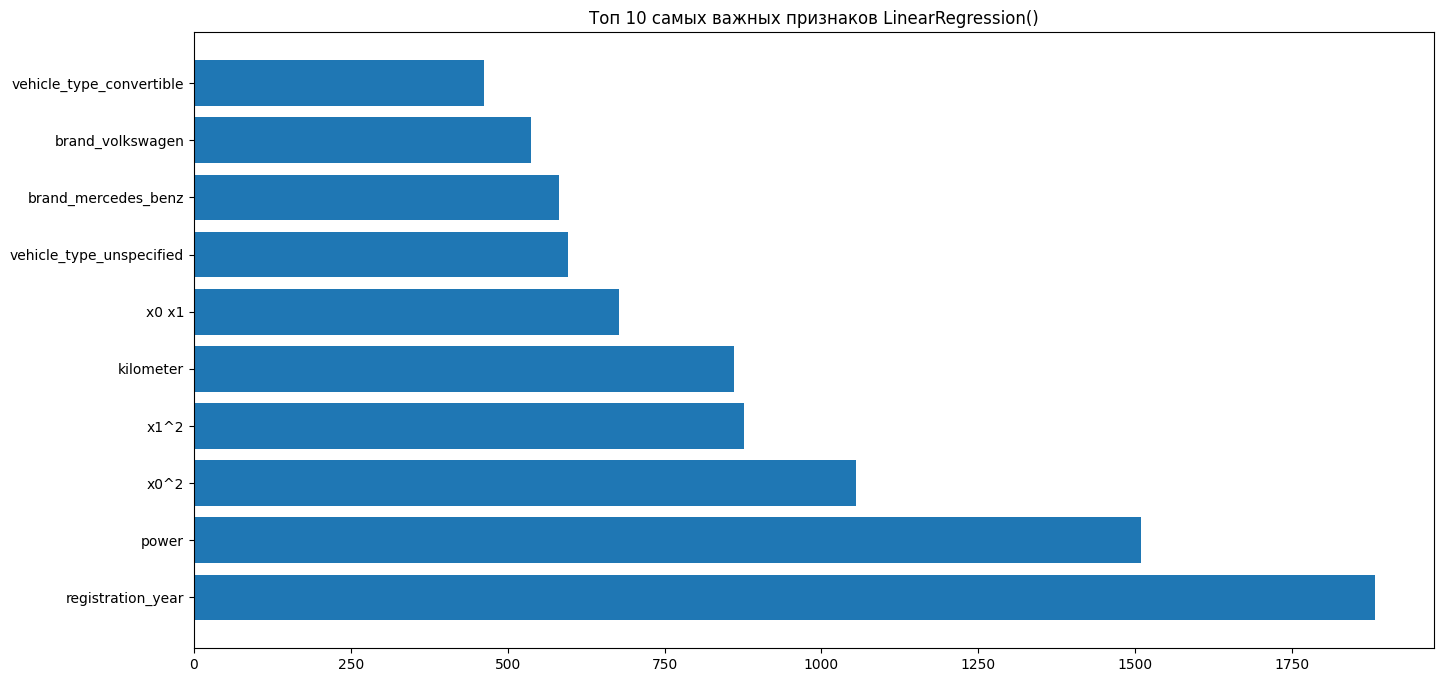

In [106]:
importance = theory_of_everything_line[0].best_estimator_.coef_
imp = pd.DataFrame(list(abs(importance)), index=list(features_train_line_pl_ohe_sc.columns)).sort_values(by=0, ascending=False)
plt.figure(figsize=(16,8))
plt.barh(imp.head(10).index, imp.head(10).values.ravel())
plt.title('Топ 10 самых важных признаков LinearRegression()')
plt.show()

Важность признаков LinearRegression()

In [107]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(pd.DataFrame(importance, index=features_train_line_pl_ohe_sc.columns).abs().sort_values(by=0, ascending=False))

,0
registration_year,1882.3322
power,1508.6841
x0^2,1054.8590
x1^2,876.8677
kilometer,861.4848
...,...
model_materia,0.7450
model_range_rover_sport,0.7113
model_c_max,0.5998
model_getz,0.5838


Главные показатели моделей

In [108]:
main_values_line = results_line.sort_values(by='mean_test_score').groupby('model').first().reset_index()
analysis_line = pd.concat([
    main_values_line[['model', 'mean_test_score', 'grid_time']],
    pd.DataFrame([*main_values_line['params']]),
], axis=1)

main_values_boosting = results_boosting.sort_values(by='mean_test_score').groupby('model').first().reset_index()
analysis_boosting = pd.concat([
    main_values_boosting[['model', 'mean_test_score', 'grid_time']],
    pd.DataFrame([*main_values_boosting['params']]),
], axis=1)

s = analysis_line['mean_test_score'] / analysis_line['mean_test_score'].max() * 100
g = analysis_line['grid_time'] / analysis_line['grid_time'].max() * 100
analysis_line['efficiency'] = s / g

s = analysis_boosting['mean_test_score'] / analysis_boosting['mean_test_score'].max() * 100
g = analysis_boosting['grid_time'] / analysis_boosting['grid_time'].max() * 100
analysis_boosting['efficiency'] = s / g

Сортировка по метрике начиная с лучшей модели

In [109]:
analysis_line.sort_values(by='mean_test_score')

,model,mean_test_score,grid_time,loss,penalty,max_depth,n_estimators,efficiency
2,XGBRegressor,1726.261722,17.693142,NaN,NaN,9.0,20.0,7.202524
0,LinearRegression,2877.038919,30.317155,NaN,NaN,NaN,NaN,7.005520
1,SGDRegressor,4216.564244,311.273247,epsilon_insensitive,l2,NaN,NaN,1.000000


In [110]:
analysis_boosting.sort_values(by='mean_test_score')

,model,mean_test_score,grid_time,depth,learning_rate,n_estimators,max_depth,num_leaves,efficiency
0,CatBoostRegressor,1827.170232,44.939965,9.0,1,20,NaN,NaN,0.913615
1,LGBMRegressor,1999.934329,19.590370,NaN,1,20,8.0,9.0,2.293982


Сортировка по времени обучения модели начиная с лучшего

In [111]:
analysis_line.sort_values(by='grid_time')

,model,mean_test_score,grid_time,loss,penalty,max_depth,n_estimators,efficiency
2,XGBRegressor,1726.261722,17.693142,NaN,NaN,9.0,20.0,7.202524
0,LinearRegression,2877.038919,30.317155,NaN,NaN,NaN,NaN,7.005520
1,SGDRegressor,4216.564244,311.273247,epsilon_insensitive,l2,NaN,NaN,1.000000


In [112]:
analysis_boosting.sort_values(by='grid_time')

,model,mean_test_score,grid_time,depth,learning_rate,n_estimators,max_depth,num_leaves,efficiency
1,LGBMRegressor,1999.934329,19.590370,NaN,1,20,8.0,9.0,2.293982
0,CatBoostRegressor,1827.170232,44.939965,9.0,1,20,NaN,NaN,0.913615


Сортировка по эффективности наченая с самой эффективной

In [113]:
analysis_line.sort_values(by='efficiency', ascending=False)

,model,mean_test_score,grid_time,loss,penalty,max_depth,n_estimators,efficiency
2,XGBRegressor,1726.261722,17.693142,NaN,NaN,9.0,20.0,7.202524
0,LinearRegression,2877.038919,30.317155,NaN,NaN,NaN,NaN,7.005520
1,SGDRegressor,4216.564244,311.273247,epsilon_insensitive,l2,NaN,NaN,1.000000


In [114]:
analysis_boosting.sort_values(by='efficiency', ascending=False)

,model,mean_test_score,grid_time,depth,learning_rate,n_estimators,max_depth,num_leaves,efficiency
1,LGBMRegressor,1999.934329,19.590370,NaN,1,20,8.0,9.0,2.293982
0,CatBoostRegressor,1827.170232,44.939965,9.0,1,20,NaN,NaN,0.913615


## Вывод

Были обучены модели регрессии различных архитектур с помощью градиентного бустинга для задачи наиболее точного определения рыночной стоимости автомобиля. Выбраны лучшие в каждой архитектуре, для данной сетки гиперпараметров. Проведён сравнительный анализ моделей.

`LinearRegression` и `SGDRegressor` не удалось достигнуть метрики RMSE в 2500. По `LinearRegression` был показан "вклад" признаков в стоимость автомобиля. Топ 6 это: год регистрации, мощность и километраж и их полиномиальные варианты.

Самой "эффективной" архитектурой в расчёте полученной метрики за единицу времени оказался `CatBoostRegressor`, для данных сеток гиперпараметров. Лучшая метрика 1722 у `XGBRegressor`.

Сохранены все варианты гиперпараметров и результаты обучаемых моделей.

Была достигнута метрика **RMSE** для `LGBMRegressor` лучше чем 2500, а именно **1998** на обучающей и **1936** на тестовой выборке. Обученная модель сохранена в файл для дальнейшего использования.